## Import_simulation Examples
Shows how to use the ``import_simulation`` method to continue simulating from a previous simulaton. 
- branching example: only first part of the apical dendrite grows initial simulation, after importing the database growth continues and oblique and tuft dendrites branch off: [Branching_example](#Branching_example)
- additional attributes example: if user defined additional attributes are stored properly they will also be imported: [Attributes_example](#Attributes_example)

### Branching_example
The code is identical to the **Interstitial Branching Example** in the *Interstitial Growth* notebook.  
First short run to create a new database to import, only apical dendrite grows without branching:

<IPython.core.display.Javascript object>


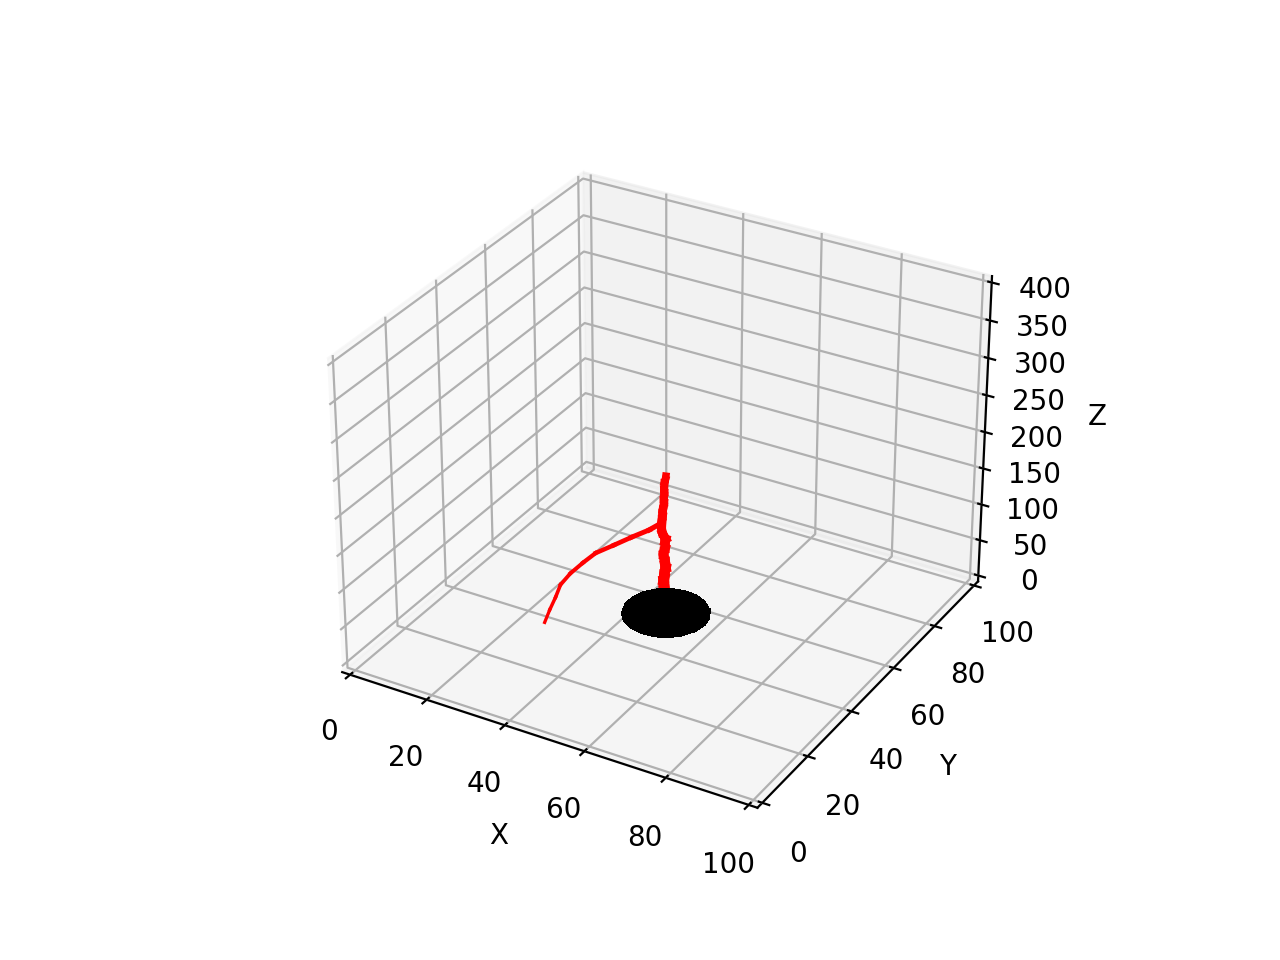

In [1]:
%matplotlib notebook

from neurodevsim.simulator import *

pia = 396 # z location of the pia
dir_to_pia = Point(0.,0.,4.) # length 4 vector towards pia

class InterstitialFront(Front):

    # defined layers to make the switches
    def manage_front(self,constellation):
        if self.swc_type == 1: # the soma
            # first segment of apical dendrite, grow out of soma
            new_pos = self.orig + Point(0.0,0.0,14.0)
            # this should always work -> no try/except code
            new_front = self.add_child(constellation,new_pos,radius=2.,swc_type=4) # make a new front and store it
            self.disable(constellation) # soma becomes inactive
        elif self.swc_type == 4: # apical dendrite: can sprout obliques later
            if self.end.z > pia:  # reached pia without tufted dendrite, terminate growth
                self.disable(constellation)
                return
            if self.num_children == 0: # initial extension of apical dendrite
                # check whether we should branch into tufted dendrite
                tufted = (self.path_length >= 220) and (np.random.random() < 0.4) # store decision
                count = 0 # counts number of add_child trials
                while count < 10: # try multiple times if needed
                    if tufted: # make tufted dendrite
                        rad = self.taper(0.8) # taper radius a lot
                        num_dendr = 0
                        rnd_dirs = self.unit_branching_sample(5) # generate more points than needed
                        for p in rnd_dirs: # make 2 branches
                            new_pos = self.end + dir_to_pia + p * 4.
                            # check for possible collisions
                            try:
                                new_front = self.add_child(constellation,new_pos,radius=rad,swc_type=9) # make a new front and store it
                                num_dendr += 1
                                if num_dendr == 2: # enough dendrites made
                                    # make front inactive: stops growing -> will not call this method again
                                    self.disable(constellation)
                                    return # done for this cycle
                            except (CollisionError, GridCompetitionError, InsideParentError, VolumeError):
                                count += 1
                                continue # pick another new_pos, no attempt to correct the error
                        # did not branch
                        if self.num_children > 0: # single child made -> make front inactive
                            self.disable(constellation)
                            return
                    else: # extend apical dendrite
                        rad = self.taper(0.99)
                        rnd_dir = self.unit_heading_sample(width=15)
                        new_pos = self.end + dir_to_pia + rnd_dir * 0.5
                        try:
                            new_front = self.add_child(constellation,new_pos,radius=rad) # make a new front and store it
                            if (self.path_length < 50.): # close to soma, only extension
                                self.disable(constellation) # no interstitial growth
                            return # done for this cycle
                        except (CollisionError, GridCompetitionError, InsideParentError, VolumeError):
                            count += 1
                            continue # pick another new_pos, no attempt to correct the error
            else: # check for interstitial growth of apical dendrite
                if np.random.random() < 0.0025: # make oblique dendrite
                    rad = self.taper(0.6) # taper radius a lot
                    count = 0 # counts number of add_child trials
                    while count < 10: # try multiple times if needed
                        rnd_dir = self.unit_heading_sample(mean=90,width=10) # close to perpendicular
                        new_pos = self.end + rnd_dir * 4.0
                        try:
                            new_front = self.add_child(constellation,new_pos,radius=rad,swc_type=8) # make a new front and store it
                            self.disable(constellation) # stop interstitial growth
                             # stop interstitial branching within 10 µm distance
                            neighbors = self.get_neighbors(constellation,10.,branch_stop=True)
                            for front in neighbors:
                                if front.is_active():
                                    front.disable(constellation) # stop interstitial growth
                            return # done for this cycle
                        except (CollisionError, GridCompetitionError, InsideParentError, VolumeError):
                            count += 1
                            continue # pick another new_pos, no attempt to correct the error
                    # did not grow
                    self.disable(constellation) # stop trying

        elif self.swc_type == 8: # oblique dendrite: not influenced by pia
            if self.path_length > 250: # stop growing
                self.disable(constellation)
                return 
            rad = self.taper(0.95) # taper radius
            count = 0 # counts number of add_child trials
            while count < 10: # try multiple times if needed
                rnd_dir = self.unit_heading_sample(width=10)
                new_pos = self.end + rnd_dir * 5.0
                #print (self,new_pos,rad)
                try:
                    new_front = self.add_child(constellation,new_pos,radius=rad) # make a new front and store it
                    # make front inactive: stops growing -> will not call this method again
                    self.disable(constellation)
                    return # done for this cycle
                except (CollisionError, GridCompetitionError, InsideParentError, VolumeError) as error:
                    #print (constellation.cycle,self._fid,error)
                    count += 1
                    continue # pick another new_pos, no attempt to correct the error
            # did not grow
            self.disable(constellation) # stop trying
        else: # tufted dendrite, attracted by pia
            if self.end.z > pia:  # reached pia, terminate growth
                self.disable(constellation)
                return
            branch = (self.order < 4) and (np.random.random() < 0.1) # store decision
            count = 0 # counts number of add_child trials
            while count < 10: # try multiple times if needed
                if branch: # make tufted dendrite
                    rad = self.taper(0.8) # taper radius a lot
                    num_dendr = 0
                    rnd_dirs = self.unit_branching_sample(5) # generate more points than needed
                    for p in rnd_dirs: # make 2 branches
                        new_pos = self.end + dir_to_pia + p * 4.0
                        # check for possible collisions
                        try:
                            new_front = self.add_child(constellation,new_pos,radius=rad) # make a new front and store it
                            num_dendr += 1
                            if num_dendr == 2: # enough dendrites made
                                # make front inactive: stops growing -> will not call this method again
                                self.disable(constellation)
                                return # done for this cycle
                        except (CollisionError, GridCompetitionError, InsideParentError, VolumeError):
                            count += 1
                            continue # pick another new_pos, no attempt to correct the error
                    # did not branch
                    if self.num_children > 0: # single child made -> make front inactive
                        self.disable(constellation)
                        return
                else: # extend tufted dendrite
                    rad = self.taper(0.99)
                    rnd_dir = self.unit_heading_sample(width=15)
                    new_pos = self.end + dir_to_pia + rnd_dir * 0.5
                    try:
                        new_front = self.add_child(constellation,new_pos,radius=rad) # make a new front and store it
                        self.disable(constellation) # no interstitial growth
                        return # done for this cycle
                    except (CollisionError, GridCompetitionError, InsideParentError, VolumeError) as error:
                        count += 1
                        continue # pick another new_pos, no attempt to correct the error
            

if __name__ == '__main__':

    fname = "output/interstitial_test0.db"
    sim_volume = [[0., 0., 0.], [100.0,100.0,400.0]]
    neuron_types = [InterstitialFront]
    admin = Admin_agent(4,fname,sim_volume,neuron_types,verbose=0,plot=True)
    
    # This flag has to be set to make the database importable
    admin.importable_db = True
    
    admin.add_neurons(InterstitialFront,"interstitial",1,[[50,50,10],[50,50,10]],10.)

    admin.simulation_loop(40)

    admin.destruction()

Import the database and continue the simulation run: it is as if the simulation was not interrupted...  

<IPython.core.display.Javascript object>


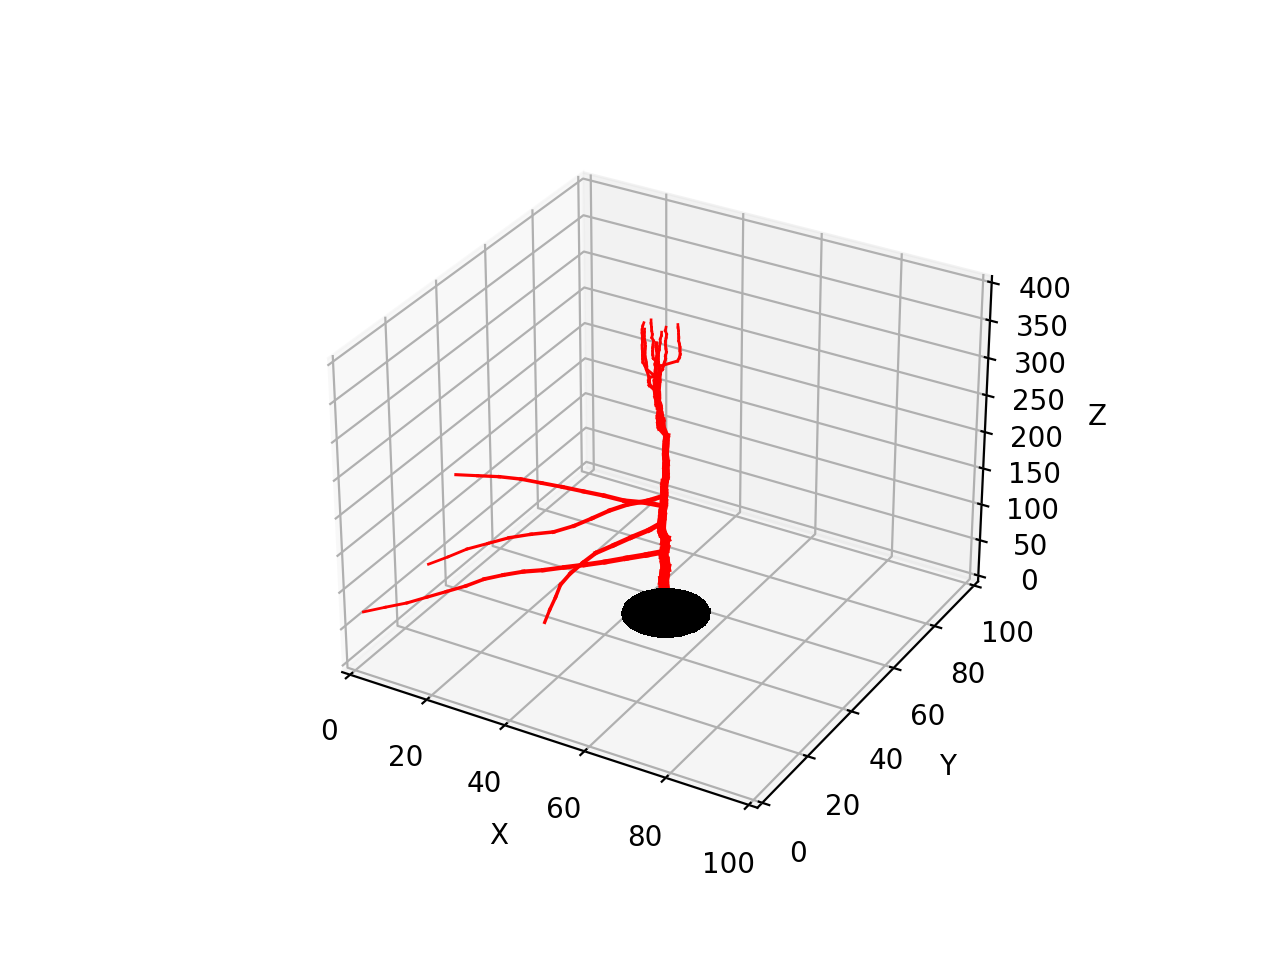

In [2]:
%matplotlib notebook

from neurodevsim.simulator import *

pia = 396 # z location of the pia
dir_to_pia = Point(0.,0.,4.) # length 4 vector towards pia

class InterstitialFront(Front):

    # defined layers to make the switches
    def manage_front(self,constellation):
        if self.swc_type == 1: # the soma
            # first segment of apical dendrite, grow out of soma
            new_pos = self.orig + Point(0.0,0.0,14.0)
            # this should always work -> no try/except code
            new_front = self.add_child(constellation,new_pos,radius=2.,swc_type=4) # make a new front and store it
            self.disable(constellation) # soma becomes inactive
        elif self.swc_type == 4: # apical dendrite: can sprout obliques later
            if self.end.z > pia:  # reached pia without tufted dendrite, terminate growth
                self.disable(constellation)
                return
            if self.num_children == 0: # initial extension of apical dendrite
                # check whether we should branch into tufted dendrite
                tufted = (self.path_length >= 220) and (np.random.random() < 0.4) # store decision
                count = 0 # counts number of add_child trials
                while count < 10: # try multiple times if needed
                    if tufted: # make tufted dendrite
                        rad = self.taper(0.8) # taper radius a lot
                        num_dendr = 0
                        rnd_dirs = self.unit_branching_sample(5) # generate more points than needed
                        for p in rnd_dirs: # make 2 branches
                            new_pos = self.end + dir_to_pia + p * 4.
                            # check for possible collisions
                            try:
                                new_front = self.add_child(constellation,new_pos,radius=rad,swc_type=9) # make a new front and store it
                                num_dendr += 1
                                if num_dendr == 2: # enough dendrites made
                                    # make front inactive: stops growing -> will not call this method again
                                    self.disable(constellation)
                                    return # done for this cycle
                            except (CollisionError, GridCompetitionError, InsideParentError, VolumeError):
                                count += 1
                                continue # pick another new_pos, no attempt to correct the error
                        # did not branch
                        if self.num_children > 0: # single child made -> make front inactive
                            self.disable(constellation)
                            return
                    else: # extend apical dendrite
                        rad = self.taper(0.99)
                        rnd_dir = self.unit_heading_sample(width=15)
                        new_pos = self.end + dir_to_pia + rnd_dir * 0.5
                        try:
                            new_front = self.add_child(constellation,new_pos,radius=rad) # make a new front and store it
                            if (self.path_length < 50.): # close to soma, only extension
                                self.disable(constellation) # no interstitial growth
                            return # done for this cycle
                        except (CollisionError, GridCompetitionError, InsideParentError, VolumeError):
                            count += 1
                            continue # pick another new_pos, no attempt to correct the error
            else: # check for interstitial growth of apical dendrite
                if np.random.random() < 0.0025: # make oblique dendrite
                    rad = self.taper(0.6) # taper radius a lot
                    count = 0 # counts number of add_child trials
                    while count < 10: # try multiple times if needed
                        rnd_dir = self.unit_heading_sample(mean=90,width=10) # close to perpendicular
                        new_pos = self.end + rnd_dir * 4.0
                        try:
                            new_front = self.add_child(constellation,new_pos,radius=rad,swc_type=8) # make a new front and store it
                            self.disable(constellation) # stop interstitial growth
                             # stop interstitial branching within 10 µm distance
                            neighbors = self.get_neighbors(constellation,10.,branch_stop=True)
                            for front in neighbors:
                                if front.is_active():
                                    front.disable(constellation) # stop interstitial growth
                            return # done for this cycle
                        except (CollisionError, GridCompetitionError, InsideParentError, VolumeError):
                            count += 1
                            continue # pick another new_pos, no attempt to correct the error
                    # did not grow
                    self.disable(constellation) # stop trying

        elif self.swc_type == 8: # oblique dendrite: not influenced by pia
            if self.path_length > 250: # stop growing
                self.disable(constellation)
                return 
            rad = self.taper(0.95) # taper radius
            count = 0 # counts number of add_child trials
            while count < 10: # try multiple times if needed
                rnd_dir = self.unit_heading_sample(width=10)
                new_pos = self.end + rnd_dir * 5.0
                #print (self,new_pos,rad)
                try:
                    new_front = self.add_child(constellation,new_pos,radius=rad) # make a new front and store it
                    # make front inactive: stops growing -> will not call this method again
                    self.disable(constellation)
                    return # done for this cycle
                except (CollisionError, GridCompetitionError, InsideParentError, VolumeError) as error:
                    #print (constellation.cycle,self._fid,error)
                    count += 1
                    continue # pick another new_pos, no attempt to correct the error
            # did not grow
            self.disable(constellation) # stop trying
        else: # tufted dendrite, attracted by pia
            if self.end.z > pia:  # reached pia, terminate growth
                self.disable(constellation)
                return
            branch = (self.order < 4) and (np.random.random() < 0.1) # store decision
            count = 0 # counts number of add_child trials
            while count < 10: # try multiple times if needed
                if branch: # make tufted dendrite
                    rad = self.taper(0.8) # taper radius a lot
                    num_dendr = 0
                    rnd_dirs = self.unit_branching_sample(5) # generate more points than needed
                    for p in rnd_dirs: # make 2 branches
                        new_pos = self.end + dir_to_pia + p * 4.0
                        # check for possible collisions
                        try:
                            new_front = self.add_child(constellation,new_pos,radius=rad) # make a new front and store it
                            num_dendr += 1
                            if num_dendr == 2: # enough dendrites made
                                # make front inactive: stops growing -> will not call this method again
                                self.disable(constellation)
                                return # done for this cycle
                        except (CollisionError, GridCompetitionError, InsideParentError, VolumeError):
                            count += 1
                            continue # pick another new_pos, no attempt to correct the error
                    # did not branch
                    if self.num_children > 0: # single child made -> make front inactive
                        self.disable(constellation)
                        return
                else: # extend tufted dendrite
                    rad = self.taper(0.99)
                    rnd_dir = self.unit_heading_sample(width=15)
                    new_pos = self.end + dir_to_pia + rnd_dir * 0.5
                    try:
                        new_front = self.add_child(constellation,new_pos,radius=rad) # make a new front and store it
                        self.disable(constellation) # no interstitial growth
                        return # done for this cycle
                    except (CollisionError, GridCompetitionError, InsideParentError, VolumeError) as error:
                        count += 1
                        continue # pick another new_pos, no attempt to correct the error
            

if __name__ == '__main__':

    fname = "output/interstitial_test1.db"
    sim_volume = [[0., 0., 0.], [100.0,100.0,400.0]]
    neuron_types = [InterstitialFront]
    admin = Admin_agent(4,fname,sim_volume,neuron_types,verbose=0,plot=True)
    
    # import previous simulation: this should be first call after creating Admin_agent
    admin.import_simulation("output/interstitial_test0.db")
                            
    admin.simulation_loop(40)

    admin.destruction()

Second run after import results in different growth patterns because of difference in random numbers used. This happens even if a random *seed* is specified, see discussion of random seeds in the **Beginner's Tutorial** section in the documentation.

<IPython.core.display.Javascript object>


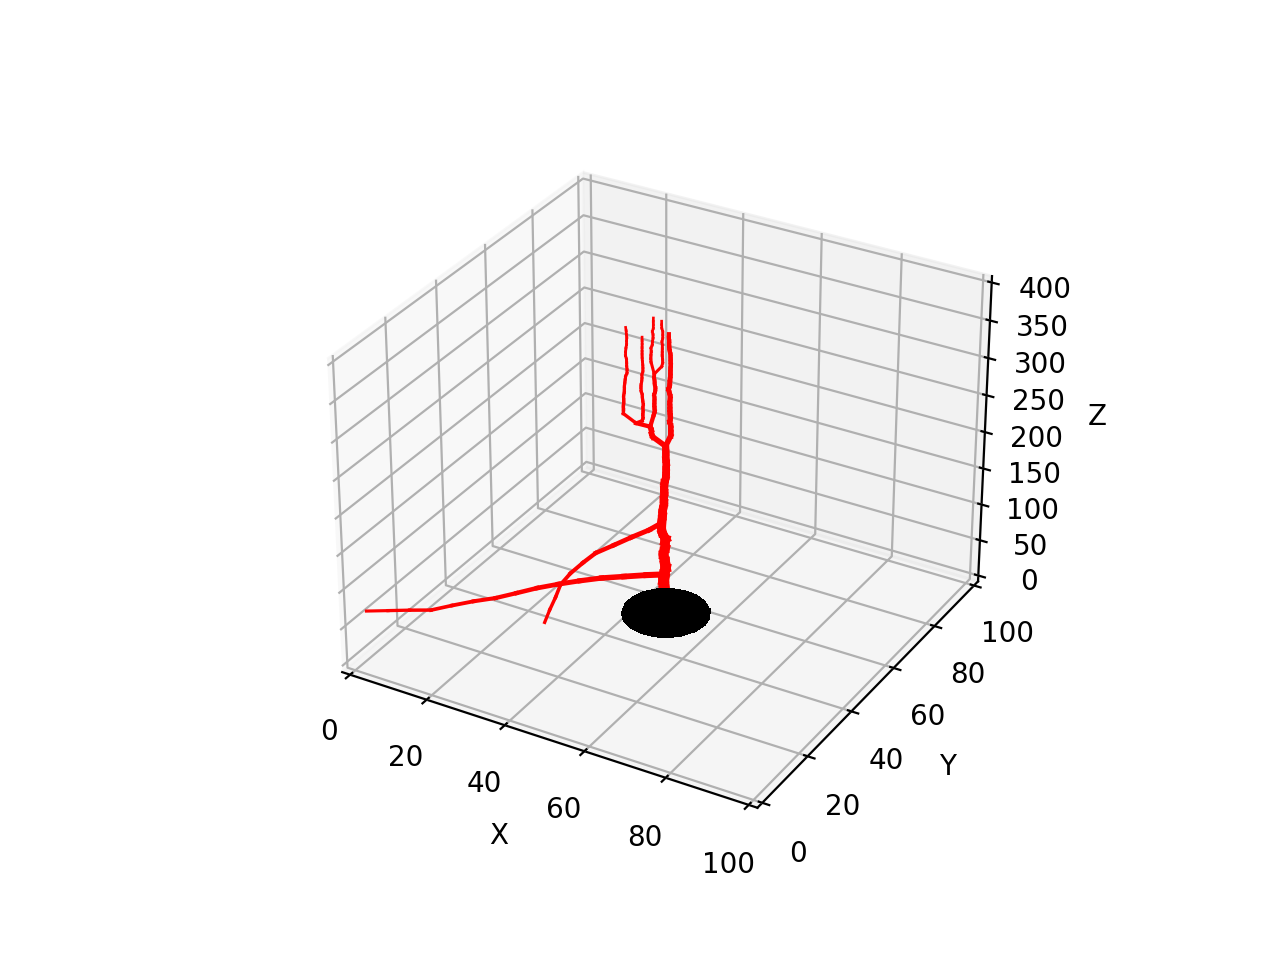

In [3]:
%matplotlib notebook

from neurodevsim.simulator import *

pia = 396 # z location of the pia
dir_to_pia = Point(0.,0.,4.) # length 4 vector towards pia

class InterstitialFront(Front):

    # defined layers to make the switches
    def manage_front(self,constellation):
        if self.swc_type == 1: # the soma
            # first segment of apical dendrite, grow out of soma
            new_pos = self.orig + Point(0.0,0.0,14.0)
            # this should always work -> no try/except code
            new_front = self.add_child(constellation,new_pos,radius=2.,swc_type=4) # make a new front and store it
            self.disable(constellation) # soma becomes inactive
        elif self.swc_type == 4: # apical dendrite: can sprout obliques later
            if self.end.z > pia:  # reached pia without tufted dendrite, terminate growth
                self.disable(constellation)
                return
            if self.num_children == 0: # initial extension of apical dendrite
                # check whether we should branch into tufted dendrite
                tufted = (self.path_length >= 220) and (np.random.random() < 0.4) # store decision
                count = 0 # counts number of add_child trials
                while count < 10: # try multiple times if needed
                    if tufted: # make tufted dendrite
                        rad = self.taper(0.8) # taper radius a lot
                        num_dendr = 0
                        rnd_dirs = self.unit_branching_sample(5) # generate more points than needed
                        for p in rnd_dirs: # make 2 branches
                            new_pos = self.end + dir_to_pia + p * 4.
                            # check for possible collisions
                            try:
                                new_front = self.add_child(constellation,new_pos,radius=rad,swc_type=9) # make a new front and store it
                                num_dendr += 1
                                if num_dendr == 2: # enough dendrites made
                                    # make front inactive: stops growing -> will not call this method again
                                    self.disable(constellation)
                                    return # done for this cycle
                            except (CollisionError, GridCompetitionError, InsideParentError, VolumeError):
                                count += 1
                                continue # pick another new_pos, no attempt to correct the error
                        # did not branch
                        if self.num_children > 0: # single child made -> make front inactive
                            self.disable(constellation)
                            return
                    else: # extend apical dendrite
                        rad = self.taper(0.99)
                        rnd_dir = self.unit_heading_sample(width=15)
                        new_pos = self.end + dir_to_pia + rnd_dir * 0.5
                        try:
                            new_front = self.add_child(constellation,new_pos,radius=rad) # make a new front and store it
                            if (self.path_length < 50.): # close to soma, only extension
                                self.disable(constellation) # no interstitial growth
                            return # done for this cycle
                        except (CollisionError, GridCompetitionError, InsideParentError, VolumeError):
                            count += 1
                            continue # pick another new_pos, no attempt to correct the error
            else: # check for interstitial growth of apical dendrite
                if np.random.random() < 0.0025: # make oblique dendrite
                    rad = self.taper(0.6) # taper radius a lot
                    count = 0 # counts number of add_child trials
                    while count < 10: # try multiple times if needed
                        rnd_dir = self.unit_heading_sample(mean=90,width=10) # close to perpendicular
                        new_pos = self.end + rnd_dir * 4.0
                        try:
                            new_front = self.add_child(constellation,new_pos,radius=rad,swc_type=8) # make a new front and store it
                            self.disable(constellation) # stop interstitial growth
                             # stop interstitial branching within 10 µm distance
                            neighbors = self.get_neighbors(constellation,10.,branch_stop=True)
                            for front in neighbors:
                                if front.is_active():
                                    front.disable(constellation) # stop interstitial growth
                            return # done for this cycle
                        except (CollisionError, GridCompetitionError, InsideParentError, VolumeError):
                            count += 1
                            continue # pick another new_pos, no attempt to correct the error
                    # did not grow
                    self.disable(constellation) # stop trying

        elif self.swc_type == 8: # oblique dendrite: not influenced by pia
            if self.path_length > 250: # stop growing
                self.disable(constellation)
                return 
            rad = self.taper(0.95) # taper radius
            count = 0 # counts number of add_child trials
            while count < 10: # try multiple times if needed
                rnd_dir = self.unit_heading_sample(width=10)
                new_pos = self.end + rnd_dir * 5.0
                #print (self,new_pos,rad)
                try:
                    new_front = self.add_child(constellation,new_pos,radius=rad) # make a new front and store it
                    # make front inactive: stops growing -> will not call this method again
                    self.disable(constellation)
                    return # done for this cycle
                except (CollisionError, GridCompetitionError, InsideParentError, VolumeError) as error:
                    #print (constellation.cycle,self._fid,error)
                    count += 1
                    continue # pick another new_pos, no attempt to correct the error
            # did not grow
            self.disable(constellation) # stop trying
        else: # tufted dendrite, attracted by pia
            if self.end.z > pia:  # reached pia, terminate growth
                self.disable(constellation)
                return
            branch = (self.order < 4) and (np.random.random() < 0.1) # store decision
            count = 0 # counts number of add_child trials
            while count < 10: # try multiple times if needed
                if branch: # make tufted dendrite
                    rad = self.taper(0.8) # taper radius a lot
                    num_dendr = 0
                    rnd_dirs = self.unit_branching_sample(5) # generate more points than needed
                    for p in rnd_dirs: # make 2 branches
                        new_pos = self.end + dir_to_pia + p * 4.0
                        # check for possible collisions
                        try:
                            new_front = self.add_child(constellation,new_pos,radius=rad) # make a new front and store it
                            num_dendr += 1
                            if num_dendr == 2: # enough dendrites made
                                # make front inactive: stops growing -> will not call this method again
                                self.disable(constellation)
                                return # done for this cycle
                        except (CollisionError, GridCompetitionError, InsideParentError, VolumeError):
                            count += 1
                            continue # pick another new_pos, no attempt to correct the error
                    # did not branch
                    if self.num_children > 0: # single child made -> make front inactive
                        self.disable(constellation)
                        return
                else: # extend tufted dendrite
                    rad = self.taper(0.99)
                    rnd_dir = self.unit_heading_sample(width=15)
                    new_pos = self.end + dir_to_pia + rnd_dir * 0.5
                    try:
                        new_front = self.add_child(constellation,new_pos,radius=rad) # make a new front and store it
                        self.disable(constellation) # no interstitial growth
                        return # done for this cycle
                    except (CollisionError, GridCompetitionError, InsideParentError, VolumeError) as error:
                        count += 1
                        continue # pick another new_pos, no attempt to correct the error
            

if __name__ == '__main__':

    fname = "output/interstitial_test1.db"
    sim_volume = [[0., 0., 0.], [100.0,100.0,400.0]]
    neuron_types = [InterstitialFront]
    admin = Admin_agent(4,fname,sim_volume,neuron_types,verbose=0,plot=True)
    
    # import previous simulation: this should be first call after creating Admin_agent
    admin.import_simulation("output/interstitial_test0.db")
                            
    admin.simulation_loop(40)

    admin.destruction()

### Attributes_example
Uses the **Save_attributes_continuous** example from the *Database* notebook (itself based on the **Integrated_variable_input** example of the *Synapses* notebook).  
The simulation is stopped after 50 cycles. In addition to ``SimpleNeuronFront`` *signal* as in the original **Save_attributes_continuous** example, ``AxonFront`` *goalID* and *next_branch* are also saved but on last cycle only (line 231). Their values at the end of the simulation are needed for *import_simulation* to work properly. ``AxonFront`` *firing_rate* is also stored on last cycle to ensure continuity of the simulation (otherwise neuron firing rates are reset to their initial value of 0. at ``import_simulation``, lines 232-237).

<IPython.core.display.Javascript object>


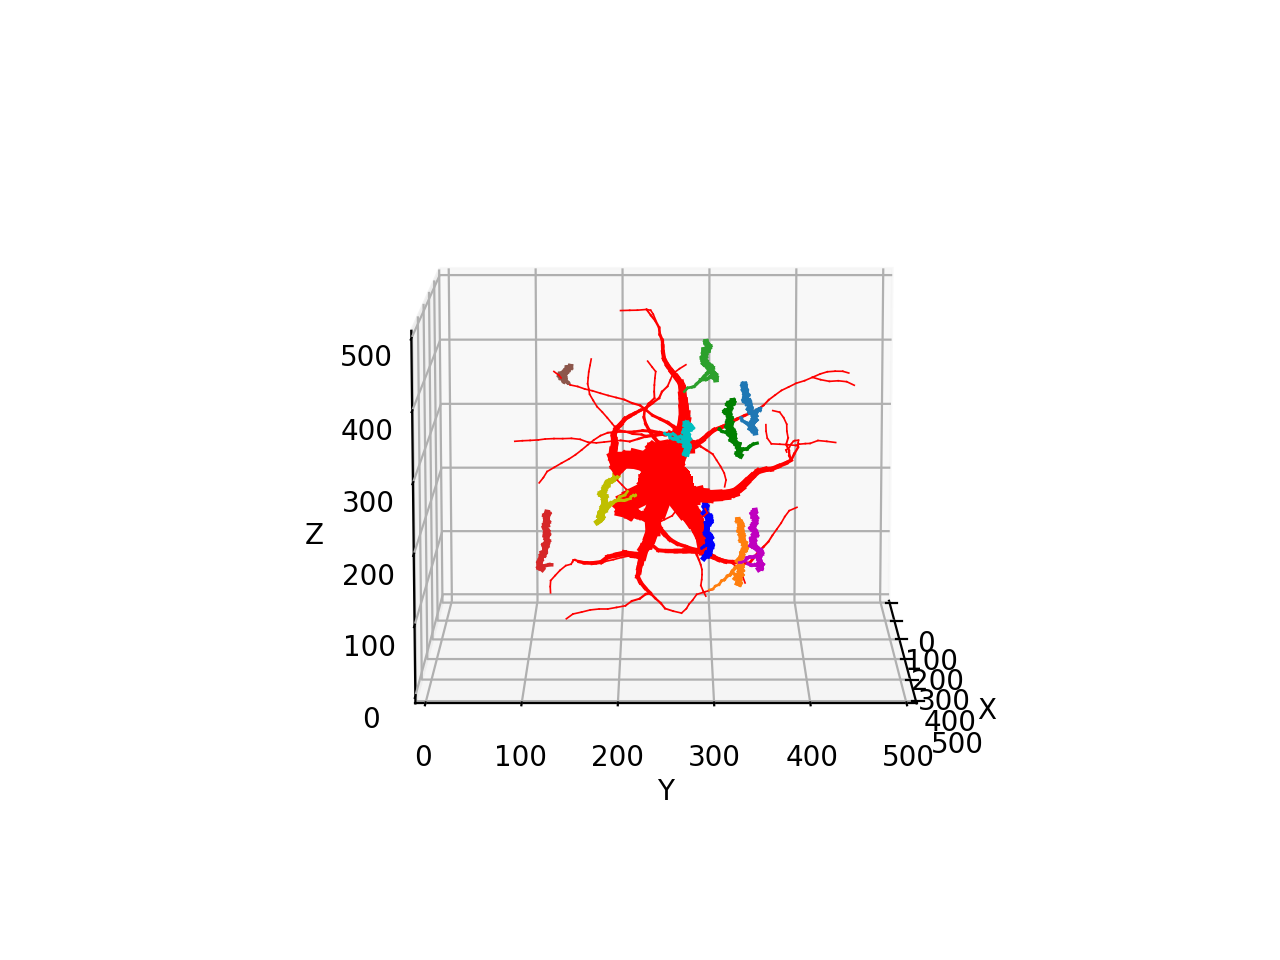

26  axon 212052 add_child failed


In [4]:
%matplotlib notebook

from neurodevsim.simulator import *
import numpy as np

# Control parameters
MAX_FR = 10. # maximum firing_rate, firing_rate will be in range 0. - MAX_FR
NEW_FR = 0.01 # probability that firing_rate will change on this cycle
SIGNAL_DECAY = 20. # rate in cycles at which signal decays back to zero.

# The postsynaptic neuron
class SimpleNeuronFront(SynFront):
    # extraintegrates syn_input over time
    _fields_ = SynFront._fields_ + [('signal', c_double)]
    
    def manage_front(self,constellation):
        if self.swc_type == 1: # this is the soma
            points = self.unit_branching_sample(16)  # generate vectors
            num_dend = 0 # count number of dendrites
            for p in points: # make 8 dendrites
                new_pos = self.orig + p * (10. + self.radius) # compute position of dendrite end
                # check for possible collisions
                try:
                    new_front = self.add_child(constellation,new_pos,radius=4.,swc_type=3) # make a new front
                    num_dend += 1
                    if num_dend == 8: # enough dendrites made
                        # make soma inactive: stops growing -> will not call this method again
                        self.disable(constellation)
                        return # completed this call
                except (CollisionError, GridCompetitionError, InsideParentError, VolumeError):
                    continue # pick another new_pos, no attempt to correct the error
            print ("Warning: less than 8 dendrites made for",self.get_neuron_name(constellation),num_dend)
            # make soma inactive: stops growing -> will not call this method again
            self.disable(constellation)
        elif self.num_children == 0: # grow if no children present
            if self.path_length >= 300:
                if self.is_postsynaptic(): # do not disable
                    self.clear_growing() # but stop growing
                else:
                    self.disable(constellation) # terminus: stop growing
                return
            bif_prob = 0.30 / (self.order*3)
            if self.order > 4 :
                bif_prob = 0.03
            if np.random.random() > bif_prob: # continue a front
                # taper radius
                rad = self.taper(0.9)
                count = 0 # counts number of add_child trials
                while count < 10:
                    # random component along current heading
                    extension = self.unit_heading_sample(width=20)
                    new_pos = self.end + extension * 10. # compute position of child end
                    # check for possible collisions
                    try:
                        new_front = self.add_child(constellation,new_pos,radius=rad) # make a new front
                        if self.is_postsynaptic(): # do not disable
                            self.clear_growing() # but stop growing
                        else: # make front inactive: stops growing
                            self.disable(constellation)
                        return # completed this call
                    except (CollisionError, GridCompetitionError, InsideParentError, VolumeError):
                        count += 1
                        continue # pick another new_pos, no attempt to correct the error
                if (constellation.cycle - self.birth) > 2: # this was second failed attempt:
                    if self.is_postsynaptic(): # do not disable
                        self.clear_growing() # but stop growing
                    else: # make front inactive: stops growing
                        self.disable(constellation)
            else: # branch a front: generate two child fronts, or terminate
                points = self.unit_branching_sample(5) # generate more points than needed
                rad = self.taper(0.7) # strongly taper radius
                num_dend = 0 # count number of dendrite branches
                for p in points: # make 2 branches
                    new_pos = self.end + p * 10.  # compute position of child end
                    # check for possible collisions
                    try:
                        new_front = self.add_child(constellation,new_pos,radius=rad) # make a new front
                        num_dend += 1
                        if num_dend == 2: # enough dendrites made
                            if self.is_postsynaptic(): # do not disable
                                self.clear_growing() # but stop growing
                            else: # make front inactive: stops growing
                                self.disable(constellation)
                            return # completed this call
                    except (CollisionError, GridCompetitionError, InsideParentError, VolumeError):
                        continue # pick another new_pos, no attempt to correct the error
                if self.num_children > 0: # single child made -> make front inactive
                    self.disable(constellation)
        else: # front has a synapse and integrates syn_input each cycle
            self.signal += self.syn_input - (self.signal / SIGNAL_DECAY)                

# Axons growing from left to right and trying to make synapses
class AxonFront(SynFront):
    # extra attributes initalized to False and 0, updated in manage_front
    _fields_ = Front._fields_ + [('goalID', ID),('next_branch',c_short)]
    # status1 is used to flag fronts on the main branch of the axon

    # Main branch grows towards left, side branches grow towards a synapse site
    def manage_front(self,constellation):
        if constellation.cycle == 1: # first axon, main not initialized
            self.set_status1() # mark as main branch
            # set initial firing rate
            neuron = self.get_neuron(constellation)
            rate = np.random.random() * MAX_FR
            neuron.set_firing_rate(constellation,rate)
            #print ("axon",neuron._neid,"initial firing rate: {:4.2f}".format(rate))
        elif self.num_children > 0: # root of axon that remains active
            if np.random.random() < NEW_FR: # change firing rate
                neuron = self.get_neuron(constellation)
                rate = np.random.random() * MAX_FR
                #print (constellation.cycle,"axon",neuron._neid,"changes firing rate from: {:4.2f}".format(neuron.firing_rate)," to: {:4.2f}".format(rate))
                neuron.set_firing_rate(constellation,rate)                
            return # do not grow anymore...
        if self.is_status1(): # continuation of main branch growing leftward
            count = 0 # counts number of add_child trials
            new_front = None
            while count < 10:
                # random component along current heading
                extension = Point(6.,0.,0.) + unit_sample_on_sphere() * 2.0
                new_pos = self.end + extension # compute position of child end
                # check for possible collisions
                try:
                    new_front = self.add_child(constellation,new_pos) # make a new front
                    new_front.set_status1() # mark as main branch
                    new_front.next_branch = max(0, self.next_branch - 1)
                    break # made a front
                except (CollisionError, GridCompetitionError, InsideParentError) as error:
                    count += 1
                    continue # pick another new_pos, no attempt to correct the error
                except (VolumeError):
                    # growing outside of volume -> stop
                    self.disable(constellation)
                    return # completed this call
            if not new_front: # add_child failed
                print (constellation.cycle,"axon",self._nid,self._fid,"add_child failed")
                self.disable(constellation)
                return # completed this call
            # check for nearby fronts: 
            targets = self.get_fronts(constellation,what='name',name="integrate_neuron",max_distance=50.)
            no_branch = True
            for t in targets: # list of (front,distance), ordered by increasing distance
                goal = t[0]
                #print (self.get_neuron_name(constellation),"testing",front)
                if goal.swc_type == 1: # do not synapse on soma
                    continue
                # check whether target front already has a synapse
                if goal.has_synapse():
                    continue
                distance = t[1]
                if distance < 1.: # close enough for a new synapse without branching
                    #print ("cycle",constellation.cycle,":",self.get_neuron_name(constellation),"makes a synapse on",goal._fid,goal._yid)
                    try:
                        self.add_synapse(constellation,goal,1.) # add synapse as presynaptic partner
                        self.disable(constellation) # no further growth of main
                        goal.enable(constellation) # make postsynaptic front active again so that it computes signal
                        return # done, no branching
                    except (SynapseError) as error:
                        print (error)
                elif self.next_branch == 0: # make a branch
                    self.goalID = goal.get_id()
                    new_front.next_branch = 5
                    rad = self.taper(0.7)
                    no_branch = False
                    break
            if no_branch:
                if self.order > 0: # terminate growth of this axon (main) branch 
                    self.disable(constellation)
                return # done, no branching
        else: # continuation of a branch
            goal = constellation.front_by_id(self.goalID)
            if goal.has_synapse(): # goal has been taken by other branch
                # start retraction of the branch, front by front
                parent = self.get_parent(constellation)
                if not parent.is_status1(): # branch front 
                    parent.enable(constellation) # make active so that it retracts also
                self.retract(constellation)
                return
            rad = self.taper(0.95)
        # grow or continue a side branch (can be initiation of first side front from main)
        direction = goal.surface_point_to(self.end) - self.end
        n_direction = direction.norm()
        distance = direction.length()
        if distance < 1.: # close enough for a new synapse
            #print ("cycle",constellation.cycle,":",self.get_neuron_name(constellation),"makes a synapse on",goal._fid)
            try:
                self.add_synapse(constellation,goal,1.) # add synapse as presynaptic partner
                goal.enable(constellation) # make postsynaptic front active again so that it computes signal
            except (SynapseError) as error:
                print (error)
            if self.order > 0: # terminate growth of this axon (main) branch 
                self.disable(constellation)
            return # done, no branching
        else: # grow nearer towards front
            count = 0 # counts number of add_child trials
            while count < 10:
                if distance < 6.: # grow very close to surface of front
                    extension = n_direction * ((distance - 1.) * 0.9) + unit_sample_on_sphere()
                else: # grow front in direction of goal with some noise
                    extension = n_direction * 5. + unit_sample_on_sphere() * 2.0
                new_pos = self.end + extension # compute position of child end
                # check for possible collisions
                try:
                    new_front = self.add_child(constellation,new_pos,radius=rad) # make a new front
                    new_front.goalID = self.goalID
                    # make front inactive: stops growing -> will not call this method again
                    if self.order > 0: # terminate growth of this axon (main) branch 
                        self.disable(constellation)
                    return # completed this call
                except (CollisionError, GridCompetitionError, InsideParentError, VolumeError):
                    count += 1
                    continue # pick another new_pos, no attempt to correct the error

if __name__ == '__main__':

    # initialize Admin_agent
    fname = "output/store_signal_cont0.db"
    sim_volume = [[0., 0., 0.], [500., 500., 500.]]
    neuron_types = [SimpleNeuronFront,AxonFront]
    admin = Admin_agent(4,fname,sim_volume,neuron_types,max_synapse=400,verbose=0,plot=True,soma_black=False,elev=10,azim=0)

    # This flag has to be set to make the database importable
    admin.importable_db = True

    # make simple neuron
    admin.add_neurons(SimpleNeuronFront,"integrate_neuron",1,[[300.0,250.0,250.0],[300.,250.,250.]],30.)

    # make 10 axons: these grow 'from outside' into the volume
    admin.add_neurons(AxonFront,"axon",10,[[1,100,100],[1,400,400]],1.,axon=[5.0,0.,0.])
    
    # save signal attribute at the end of the simulation
    admin.attrib_to_db(SimpleNeuronFront,"signal","real")
    # save goalID attribute at end of simulation
    admin.attrib_to_db(AxonFront,"goalID","id",last_only=True)
    # save next_branch attribute at end of simulation
    admin.attrib_to_db(AxonFront,"next_branch","int",last_only=True)
    # save neuron firing_rate at end of simulation
    admin.attrib_to_db(AxonFront,"firing_rate","real",object=Neuron,last_only=True)

    # run the simulation
    admin.simulation_loop(50)

    # clean up
    admin.destruction()

Next import the simulation and let it continue to run. Storage of *signal* is continued automatically.

<IPython.core.display.Javascript object>


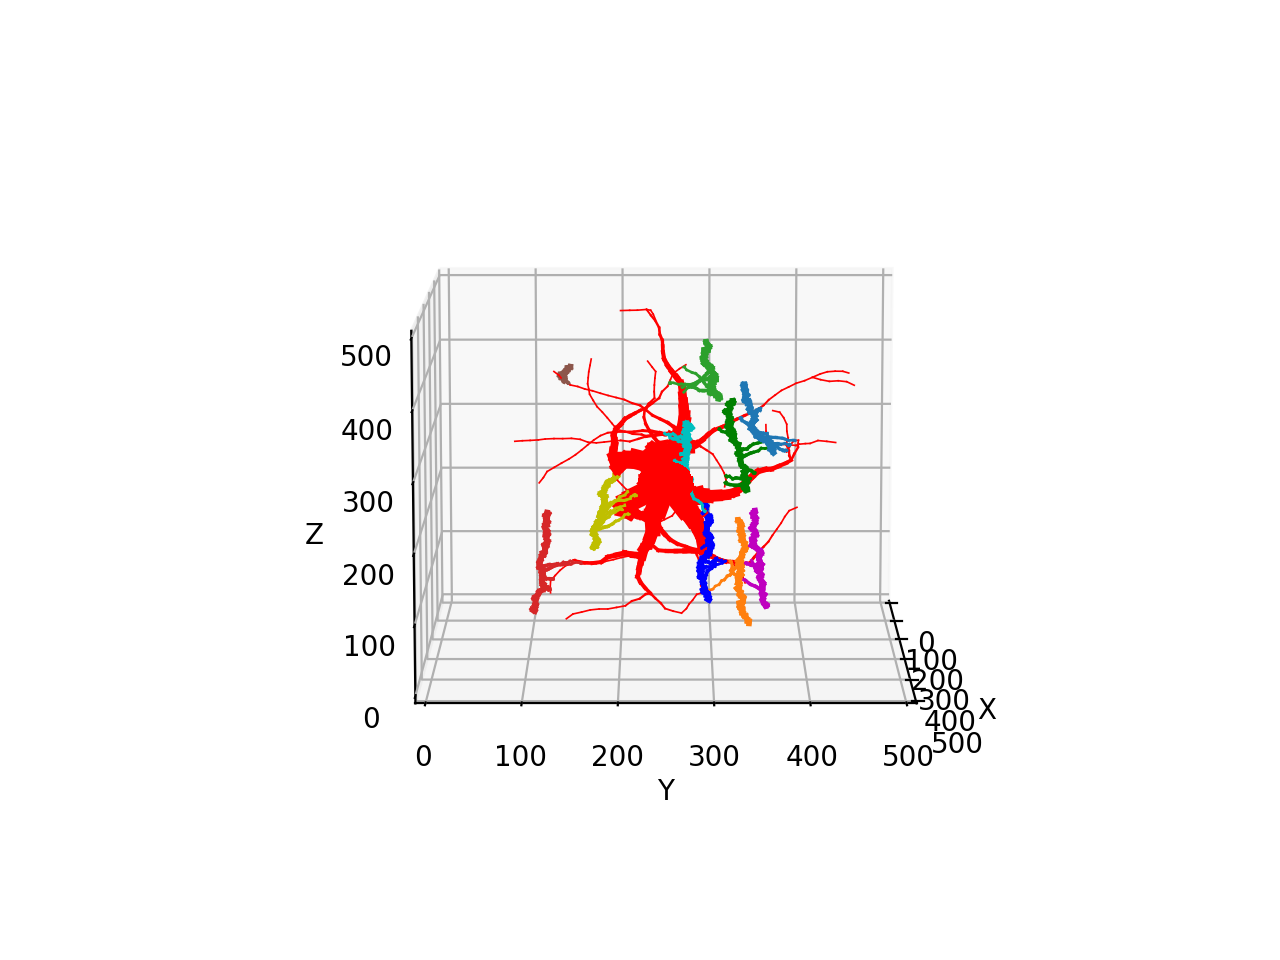

In [5]:
%matplotlib notebook

from neurodevsim.simulator import *
import numpy as np

# Control parameters
MAX_FR = 10. # maximum firing_rate, firing_rate will be in range 0. - MAX_FR
NEW_FR = 0.01 # probability that firing_rate will change on this cycle
SIGNAL_DECAY = 20. # rate in cycles at which signal decays back to zero.

# The postsynaptic neuron
class SimpleNeuronFront(SynFront):
    # extraintegrates syn_input over time
    _fields_ = SynFront._fields_ + [('signal', c_double)]
    
    def manage_front(self,constellation):
        if self.swc_type == 1: # this is the soma
            points = self.unit_branching_sample(16)  # generate vectors
            num_dend = 0 # count number of dendrites
            for p in points: # make 8 dendrites
                new_pos = self.orig + p * (10. + self.radius) # compute position of dendrite end
                # check for possible collisions
                try:
                    new_front = self.add_child(constellation,new_pos,radius=4.,swc_type=3) # make a new front
                    num_dend += 1
                    if num_dend == 8: # enough dendrites made
                        # make soma inactive: stops growing -> will not call this method again
                        self.disable(constellation)
                        return # completed this call
                except (CollisionError, GridCompetitionError, InsideParentError, VolumeError):
                    continue # pick another new_pos, no attempt to correct the error
            print ("Warning: less than 8 dendrites made for",self.get_neuron_name(constellation),num_dend)
            # make soma inactive: stops growing -> will not call this method again
            self.disable(constellation)
        elif self.num_children == 0: # grow if no children present
            if self.path_length >= 300:
                if self.is_postsynaptic(): # do not disable
                    self.clear_growing() # but stop growing
                else:
                    self.disable(constellation) # terminus: stop growing
                return
            bif_prob = 0.30 / (self.order*3)
            if self.order > 4 :
                bif_prob = 0.03
            if np.random.random() > bif_prob: # continue a front
                # taper radius
                rad = self.taper(0.9)
                count = 0 # counts number of add_child trials
                while count < 10:
                    # random component along current heading
                    extension = self.unit_heading_sample(width=20)
                    new_pos = self.end + extension * 10. # compute position of child end
                    # check for possible collisions
                    try:
                        new_front = self.add_child(constellation,new_pos,radius=rad) # make a new front
                        if self.is_postsynaptic(): # do not disable
                            self.clear_growing() # but stop growing
                        else: # make front inactive: stops growing
                            self.disable(constellation)
                        return # completed this call
                    except (CollisionError, GridCompetitionError, InsideParentError, VolumeError):
                        count += 1
                        continue # pick another new_pos, no attempt to correct the error
                if (constellation.cycle - self.birth) > 2: # this was second failed attempt:
                    if self.is_postsynaptic(): # do not disable
                        self.clear_growing() # but stop growing
                    else: # make front inactive: stops growing
                        self.disable(constellation)
            else: # branch a front: generate two child fronts, or terminate
                points = self.unit_branching_sample(5) # generate more points than needed
                rad = self.taper(0.7) # strongly taper radius
                num_dend = 0 # count number of dendrite branches
                for p in points: # make 2 branches
                    new_pos = self.end + p * 10.  # compute position of child end
                    # check for possible collisions
                    try:
                        new_front = self.add_child(constellation,new_pos,radius=rad) # make a new front
                        num_dend += 1
                        if num_dend == 2: # enough dendrites made
                            if self.is_postsynaptic(): # do not disable
                                self.clear_growing() # but stop growing
                            else: # make front inactive: stops growing
                                self.disable(constellation)
                            return # completed this call
                    except (CollisionError, GridCompetitionError, InsideParentError, VolumeError):
                        continue # pick another new_pos, no attempt to correct the error
                if self.num_children > 0: # single child made -> make front inactive
                    self.disable(constellation)
        else: # front has a synapse and integrates syn_input each cycle
            if constellation.cycle < 53:
                synapse = self.get_synapse(constellation)
                #print (self._fid,str(synapse))
            self.signal += self.syn_input - (self.signal / SIGNAL_DECAY)                

# Axons growing from left to right and trying to make synapses
class AxonFront(SynFront):
    # extra attributes initalized to False and 0, updated in manage_front
    _fields_ = Front._fields_ + [('goalID', ID),('next_branch',c_short)]
    # status1 is used to flag fronts on the main branch of the axon

    # Main branch grows towards left, side branches grow towards a synapse site
    def manage_front(self,constellation):
        if constellation.cycle < 53:
            neuron = self.get_neuron(constellation)
            #print (self._fid,neuron)
        if constellation.cycle == 1: # first axon, main not initialized
            self.set_status1() # mark as main branch
            # set initial firing rate
            neuron = self.get_neuron(constellation)
            rate = np.random.random() * MAX_FR
            neuron.set_firing_rate(constellation,rate)
            #print ("axon",neuron._neid,"initial firing rate: {:4.2f}".format(rate))
        elif self.num_children > 0: # root of axon that remains active
            if np.random.random() < NEW_FR: # change firing rate
                neuron = self.get_neuron(constellation)
                rate = np.random.random() * MAX_FR
                #print (constellation.cycle,"axon",neuron._neid,"changes firing rate from: {:4.2f}".format(neuron.firing_rate)," to: {:4.2f}".format(rate))
                neuron.set_firing_rate(constellation,rate)                
            return # do not grow anymore...
        if self.is_status1(): # continuation of main branch growing leftward
            count = 0 # counts number of add_child trials
            new_front = None
            while count < 10:
                # random component along current heading
                extension = Point(6.,0.,0.) + unit_sample_on_sphere() * 2.0
                new_pos = self.end + extension # compute position of child end
                # check for possible collisions
                try:
                    new_front = self.add_child(constellation,new_pos) # make a new front
                    new_front.set_status1() # mark as main branch
                    new_front.next_branch = max(0, self.next_branch - 1)
                    break # made a front
                except (CollisionError, GridCompetitionError, InsideParentError) as error:
                    count += 1
                    continue # pick another new_pos, no attempt to correct the error
                except (VolumeError):
                    # growing outside of volume -> stop
                    self.disable(constellation)
                    return # completed this call
            if not new_front: # add_child failed
                print (constellation.cycle,"axon",self._nid,self._fid,"add_child failed")
                self.disable(constellation)
                return # completed this call
            # check for nearby fronts: 
            targets = self.get_fronts(constellation,what='name',name="integrate_neuron",max_distance=50.)
            no_branch = True
            for t in targets: # list of (front,distance), ordered by increasing distance
                goal = t[0]
                #print (self.get_neuron_name(constellation),"testing",front)
                if goal.swc_type == 1: # do not synapse on soma
                    continue
                # check whether target front already has a synapse
                if goal.has_synapse():
                    continue
                distance = t[1]
                if distance < 1.: # close enough for a new synapse without branching
                    #print ("cycle",constellation.cycle,":",self.get_neuron_name(constellation),"makes a synapse on",goal._fid,goal._yid)
                    try:
                        self.add_synapse(constellation,goal,1.) # add synapse as presynaptic partner
                        self.disable(constellation) # no further growth of main
                        goal.enable(constellation) # make postsynaptic front active again so that it computes signal
                        return # done, no branching
                    except (SynapseError) as error:
                        print (error)
                elif self.next_branch == 0: # make a branch
                    self.goalID = goal.get_id()
                    new_front.next_branch = 5
                    rad = self.taper(0.7)
                    no_branch = False
                    break
            if no_branch:
                if self.order > 0: # terminate growth of this axon (main) branch 
                    self.disable(constellation)
                return # done, no branching
        else: # continuation of a branch
            goal = constellation.front_by_id(self.goalID)
            if goal.has_synapse(): # goal has been taken by other branch
                # start retraction of the branch, front by front
                parent = self.get_parent(constellation)
                if not parent.is_status1(): # branch front 
                    parent.enable(constellation) # make active so that it retracts also
                self.retract(constellation)
                return
            rad = self.taper(0.95)
        # grow or continue a side branch (can be initiation of first side front from main)
        direction = goal.surface_point_to(self.end) - self.end
        n_direction = direction.norm()
        distance = direction.length()
        if distance < 1.: # close enough for a new synapse
            #print ("cycle",constellation.cycle,":",self.get_neuron_name(constellation),"makes a synapse on",goal._fid)
            try:
                self.add_synapse(constellation,goal,1.) # add synapse as presynaptic partner
                goal.enable(constellation) # make postsynaptic front active again so that it computes signal
            except (SynapseError) as error:
                print (error)
            if self.order > 0: # terminate growth of this axon (main) branch 
                self.disable(constellation)
            return # done, no branching
        else: # grow nearer towards front
            count = 0 # counts number of add_child trials
            while count < 10:
                if distance < 6.: # grow very close to surface of front
                    extension = n_direction * ((distance - 1.) * 0.9) + unit_sample_on_sphere()
                else: # grow front in direction of goal with some noise
                    extension = n_direction * 5. + unit_sample_on_sphere() * 2.0
                new_pos = self.end + extension # compute position of child end
                # check for possible collisions
                try:
                    new_front = self.add_child(constellation,new_pos,radius=rad) # make a new front
                    new_front.goalID = self.goalID
                    # make front inactive: stops growing -> will not call this method again
                    if self.order > 0: # terminate growth of this axon (main) branch 
                        self.disable(constellation)
                    return # completed this call
                except (CollisionError, GridCompetitionError, InsideParentError, VolumeError):
                    count += 1
                    continue # pick another new_pos, no attempt to correct the error

if __name__ == '__main__':

    # initialize Admin_agent
    fname = "output/store_signal_cont.db"
    sim_volume = [[0., 0., 0.], [500., 500., 500.]]
    neuron_types = [SimpleNeuronFront,AxonFront]
    admin = Admin_agent(4,fname,sim_volume,neuron_types,max_synapse=400,verbose=0,plot=True,soma_black=False,elev=10,azim=0)

    # import previous simulation: this should be first call after creating Admin_agent
    admin.import_simulation("output/store_signal_cont0.db")
    
    # continue the simulation
    admin.simulation_loop(100)

    # clean up
    admin.destruction()

To confirm that ``import_simulation`` worked correctly plot some values for *signal*. There is no discontinuity of the traces at cycle 50, demonstrating that the first simulation was continued smoothly. (it may be necessary to plot more than 10 traces to include one that shows increased signal before cycle 50)

<IPython.core.display.Javascript object>


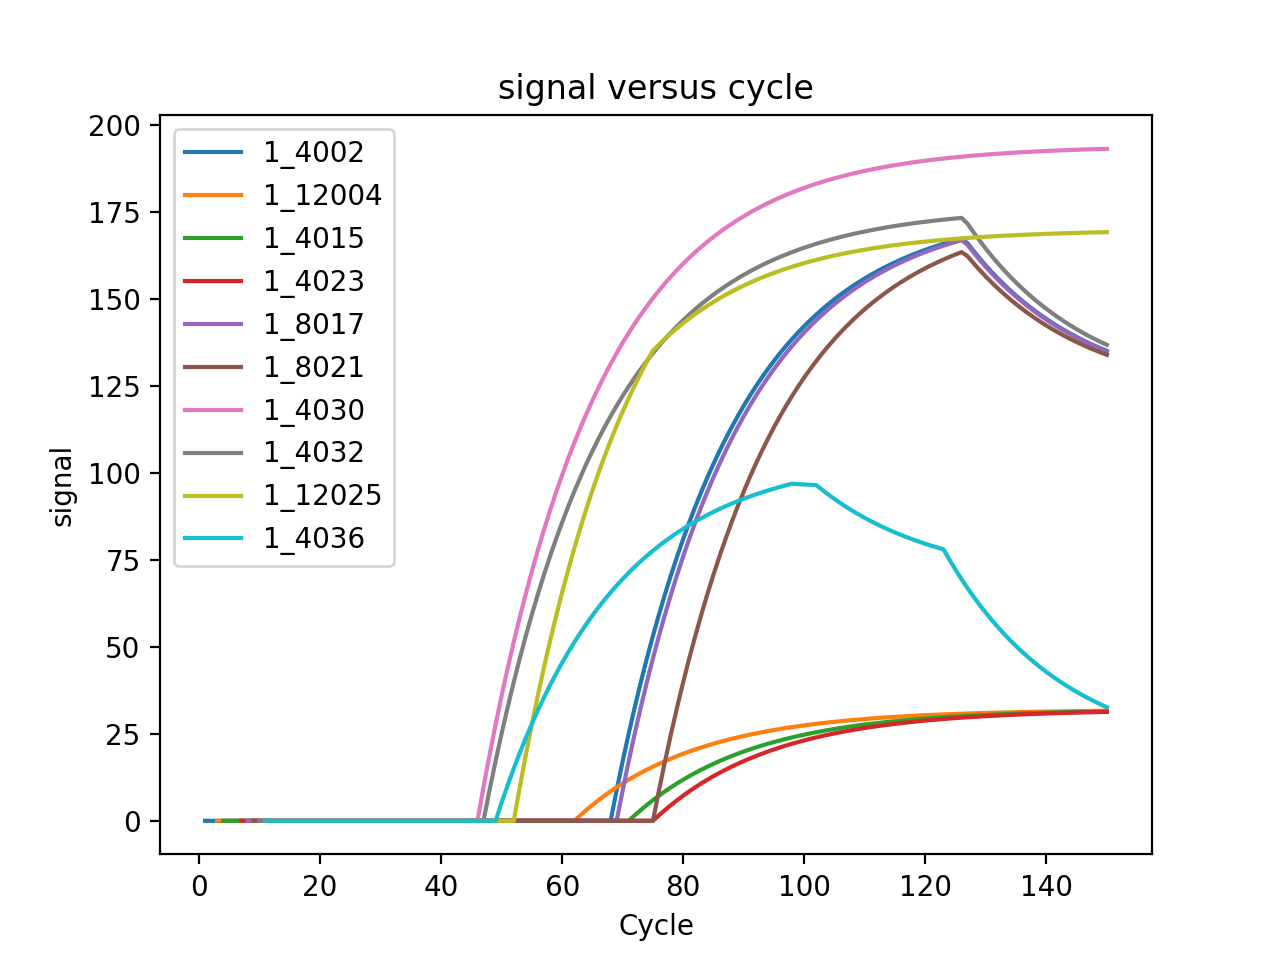

In [6]:
%matplotlib notebook
from neurodevsim.processing import *

nds_plot_data("output/store_signal_cont.db","signal",num_plots=10)